# Project: Dog vs Cat Classification

In [54]:
from pathlib import Path
import os
import torch
from torch import nn

In [55]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [56]:
data_path = Path("data/")
train_path = data_path / "train"
test_path = data_path / "test"

train_path, test_path

(WindowsPath('data/train'), WindowsPath('data/test'))

In [57]:
from PIL import Image
import random
import matplotlib.pyplot as plt
import numpy as np

Text(0.5, 1.0, 'Dog, Shape: (279, 482, 3)')

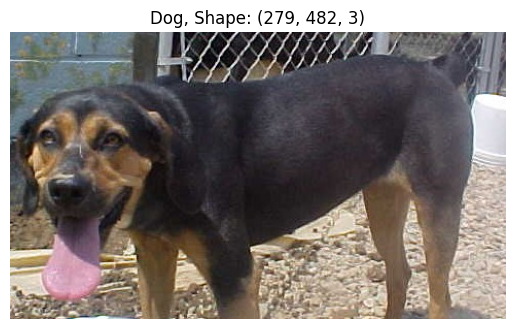

In [58]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
image_path_list = list(data_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)
img_is_array = np.asarray(img)

plt.imshow(img)
plt.axis(False)
plt.title(f"{image_class}, Shape: {img_is_array.shape}")

In [59]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [60]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [61]:
transformed_image = data_transform(img)
transformed_image

tensor([[[0.4706, 0.5020, 0.5137,  ..., 0.4431, 0.4196, 0.4118],
         [0.4549, 0.5020, 0.5098,  ..., 0.5137, 0.4588, 0.4039],
         [0.4627, 0.5020, 0.5176,  ..., 0.4588, 0.4431, 0.4078],
         ...,
         [0.7922, 0.7725, 0.7804,  ..., 0.5725, 0.5216, 0.6549],
         [0.8078, 0.7882, 0.7686,  ..., 0.5686, 0.5647, 0.6039],
         [0.7647, 0.7608, 0.6431,  ..., 0.5098, 0.5255, 0.5686]],

        [[0.4745, 0.5176, 0.5255,  ..., 0.5137, 0.5137, 0.5098],
         [0.4510, 0.5137, 0.5255,  ..., 0.5373, 0.5255, 0.5020],
         [0.4549, 0.5137, 0.5294,  ..., 0.4863, 0.5098, 0.5059],
         ...,
         [0.7294, 0.7098, 0.7176,  ..., 0.5216, 0.4667, 0.5961],
         [0.7451, 0.7294, 0.7176,  ..., 0.5333, 0.5137, 0.5373],
         [0.7176, 0.7098, 0.6118,  ..., 0.4431, 0.4627, 0.4941]],

        [[0.5216, 0.5569, 0.5490,  ..., 0.5647, 0.5765, 0.5804],
         [0.4980, 0.5569, 0.5608,  ..., 0.5255, 0.5490, 0.5569],
         [0.4980, 0.5569, 0.5725,  ..., 0.4549, 0.5412, 0.

Text(0.5, 1.0, 'Dog, Shape: torch.Size([3, 64, 64])')

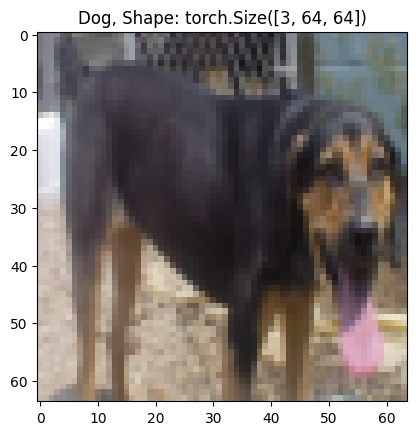

In [62]:
plt.imshow(transformed_image.permute(1, 2, 0))
plt.title(f"{image_class}, Shape: {transformed_image.shape}")

# Loading data using 'ImageFolder'

In [63]:
train_data = datasets.ImageFolder(root=train_path,
                                  transform=data_transform)

test_data = datasets.ImageFolder(root=test_path,
                                 transform=test_data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 13840
     Root location: data\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 3156
     Root location: data\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [64]:
# Get class names as list
class_names = train_data.classes
class_names

['Cat', 'Dog']

In [65]:
# Get class names as dictionary 
class_dict = train_data.class_to_idx
class_dict

{'Cat': 0, 'Dog': 1}

In [66]:
len(train_data), len(test_data)

(13840, 3156)

# Turn loaded images into 'DataLoader'

In [67]:
BATCH_SIZE = 32
NUM_WORKERS = 0

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x275f04003a0>,
 <torch.utils.data.dataloader.DataLoader at 0x275f0219b80>)

In [68]:
img_custom, label_custom = next(iter(train_dataloader))

img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [69]:
class DogVsCat(nn.Module):
    def __init__(self, input_shape, hidden_layers, output_shape):
        super().__init__()

        self.conv_block_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_layers,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.BatchNorm2d(num_features=hidden_layers),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Conv2d(in_channels=hidden_layers,
                      out_channels=hidden_layers * 2,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.BatchNorm2d(num_features=hidden_layers*2),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.conv_block_layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_layers*2,
                      out_channels=hidden_layers*2*2,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.BatchNorm2d(num_features=hidden_layers*2*2),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=hidden_layers*2*2,
                      out_channels=hidden_layers*2*2*2,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.BatchNorm2d(num_features=hidden_layers*2*2*2),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.classification = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_layers*16*16*8,
                      #out_features=output_shape
                      out_features=128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, output_shape)
        )

    def forward(self, x):
        #print(f"Shape: {x.shape}")
        x = self.conv_block_layer_1(x)
        #print(f"Shape: {x.shape}")
        x = self.conv_block_layer_2(x)
        #print(f"Shape: {x.shape}")
        x = self.classification(x)
        #print(f"Shape: {x.shape}")
        return x
        

In [70]:
model_0 = DogVsCat(input_shape=3, hidden_layers=16, output_shape=1).to(device)
model_0

DogVsCat(
  (conv_block_layer_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_layer_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6):

In [71]:
# Setup loss function and optimizer
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

loss_fn, optimizer

(BCEWithLogitsLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ))

In [72]:
# Check the correct shape on dummy tensor
dummy_input = torch.randn(32, 3, 64, 64)
output = model_0(dummy_input.to(device))
output

tensor([[ 0.3998],
        [ 0.8271],
        [ 0.3128],
        [ 0.1339],
        [ 0.0257],
        [ 0.5826],
        [ 0.2467],
        [-0.4321],
        [-0.0191],
        [ 0.8493],
        [ 0.4542],
        [ 0.0569],
        [ 0.6254],
        [-0.4189],
        [ 0.9392],
        [ 0.5124],
        [ 0.0045],
        [ 0.1954],
        [ 0.6852],
        [ 0.3934],
        [ 0.4736],
        [ 0.2038],
        [ 0.7318],
        [ 0.2116],
        [ 0.2002],
        [-0.0499],
        [-0.2152],
        [ 0.2218],
        [ 0.1523],
        [ 0.2522],
        [-0.1415],
        [ 0.2939]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [73]:
from tqdm import tqdm
import time

In [74]:
epochs = 1

start_time = time.time()

results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

for epoch in tqdm(range(epochs)):

    model_0.train()
    train_loss, train_acc = 0, 0
    
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)

        y = y.unsqueeze(dim=1).float()
        
        y_pred = model_0(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = (torch.sigmoid(y_pred) > 0.5).float()
        train_acc += (y_pred_class==y).sum().item() / len(y_pred)

    train_loss /= len(train_dataloader)
    train_acc = (train_acc / len(train_dataloader)) * 100
    
    model_0.eval()
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():
        for batch, (X, y) in enumerate(test_dataloader):
            X, y = X.to(device), y.to(device)

            y = y.unsqueeze(dim=1).float()
        
            test_pred = model_0(X)

            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            test_pred_class = (torch.sigmoid(test_pred) > 0.5).float()
            test_acc += (test_pred_class==y).sum().item() / len(test_pred)
    
        test_loss /= len(test_dataloader)
        test_acc = (test_acc / len(test_dataloader)) * 100

    print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f} | Test Loss: {test_loss}, Test Accuracy: {test_acc}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    


end_time = time.time()
train_time = end_time - start_time

print(f"Total time: {train_time}")

  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\piotr\anaconda3\envs\test\lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 1/1 [00:59<00:00, 59.81s/it]

Epoch: 0 | Train Loss: 0.8244, Train Accuracy: 53.29 | Test Loss: 0.6798685951666399, Test Accuracy: 57.752525252525245
Total time: 59.81515192985535


# Plot model_0 results

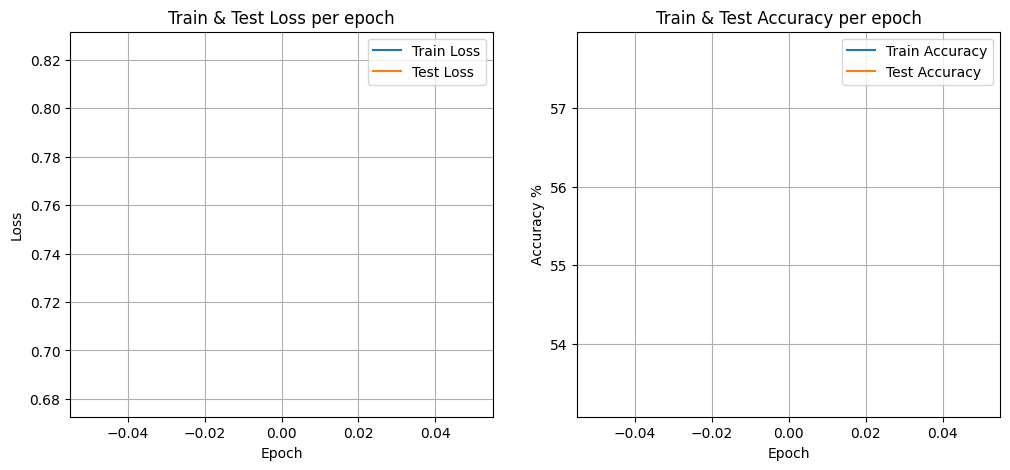

In [75]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), results["train_loss"], label="Train Loss")
plt.plot(range(epochs), results["test_loss"], label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Test Loss per epoch")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), results["train_acc"], label="Train Accuracy")
plt.plot(range(epochs), results["test_acc"], label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy %")
plt.title("Train & Test Accuracy per epoch")
plt.legend()
plt.grid()



In [76]:
print(len(results["train_loss"]), len(results["test_loss"]))
print(len(results["train_acc"]), len(results["test_acc"]))

1 1
1 1


In [77]:
# Build train and test function to make training easier
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim,
               device=device):

    train_loss, correct_preds, total_samples = 0, 0, 0
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y = y.unsqueeze(dim=1).float()
        
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        
        y_pred_class = (torch.sigmoid(y_pred) > 0.5).float()
        #train_acc += (y_pred_class==y).sum().item() / len(y_pred)
        correct_preds += (y_pred_class == y).sum().item()
        total_samples += y.size(0)

    train_loss /= len(dataloader)
    #train_acc = (train_acc / len(dataloader)) * 100
    train_acc = (correct_preds / total_samples) * 100
    
    return train_loss, train_acc

In [78]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):

    test_loss, correct_preds, total_samples = 0, 0, 0
    model.eval()
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            y = y.unsqueeze(dim=1).float()
        
            test_pred = model(X)

            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            test_pred_class = (torch.sigmoid(test_pred) > 0.5).float()
            #test_acc += (test_pred_class==y).sum().item() / len(test_pred)
            correct_preds += (test_pred_class == y).sum().item()
            total_samples += y.size(0)
    
    test_loss /= len(dataloader)
    #test_acc = (test_acc / len(dataloader)) * 100
    test_acc = (correct_preds / total_samples) * 100
    return test_loss, test_acc

# Augmentation data

In [79]:
train_data_transform_augmentation = transforms.Compose([
    #transforms.Resize(size=(64, 64)),
    transforms.RandomResizedCrop(size=(64, 64), scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=25),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    #transforms.RandomAffine(degrees=15, translate=(1, 1)),
    #transforms.TrivialAugmentWide(num_magnitude_bins=31), # used to differentiate the data
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

test_data = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
train_data_transform_augmentation, test_data

(Compose(
     RandomResizedCrop(size=(64, 64), scale=(0.9, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
     RandomHorizontalFlip(p=0.5)
     RandomRotation(degrees=[-25.0, 25.0], interpolation=nearest, expand=False, fill=0)
     ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.05, 0.05))
     GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0))
     ToTensor()
     Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
 ),
 Compose(
     Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
     ToTensor()
     Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
 ))

In [80]:
train_data_augmentation = datasets.ImageFolder(root=train_path,
                                               transform=train_data_transform_augmentation)
test_data_augmentation = datasets.ImageFolder(root=test_path,
                                              transform=test_data)

train_data_augmentation, test_data_augmentation

(Dataset ImageFolder
     Number of datapoints: 13840
     Root location: data\train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(64, 64), scale=(0.9, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
                RandomHorizontalFlip(p=0.5)
                RandomRotation(degrees=[-25.0, 25.0], interpolation=nearest, expand=False, fill=0)
                ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.05, 0.05))
                GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0))
                ToTensor()
                Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
            ),
 Dataset ImageFolder
     Number of datapoints: 3156
     Root location: data\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.

In [81]:
BATCH_SIZE = 64
NUM_WORKERS = 4

train_dataloader_augmentation = DataLoader(dataset=train_data_augmentation,
                                           batch_size=BATCH_SIZE,
                                           num_workers=NUM_WORKERS,
                                           shuffle=True)

test_dataloader_augmentation = DataLoader(dataset=test_data_augmentation,
                                          batch_size=BATCH_SIZE,
                                          num_workers=NUM_WORKERS,
                                          shuffle=False)

train_dataloader_augmentation, test_dataloader_augmentation

(<torch.utils.data.dataloader.DataLoader at 0x2759bfc2970>,
 <torch.utils.data.dataloader.DataLoader at 0x2759bfc2ee0>)

In [82]:
len(class_names)

2

In [83]:
model_1 = DogVsCat(input_shape=3, hidden_layers=8, output_shape=1).to(device)
model_1

DogVsCat(
  (conv_block_layer_1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_layer_2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU

In [84]:
# Setup loss function and optimizer
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(params=model_1.parameters(), lr=0.001, weight_decay=0.01)
                             #lr=0.00025)
#optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01, momentum=0.9)
loss_fn, optimizer

(BCEWithLogitsLoss(),
 AdamW (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0.01
 ))

In [85]:
# Train model_1 on augmentation data
epochs = 100

start_time = time.time()

results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

for epoch in tqdm(range(epochs)):

    train_loss, train_acc = train_step(model=model_1,
               dataloader=train_dataloader_augmentation,
               loss_fn=loss_fn,
               optimizer=optimizer)

    test_loss, test_acc = test_step(model=model_1,
              dataloader=test_dataloader_augmentation,
              loss_fn=loss_fn)

    print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f} | Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    


end_time = time.time()
train_time = end_time - start_time

print(f"Total time: {train_time}")

  1%|          | 1/100 [00:49<1:22:18, 49.88s/it]

Epoch: 0 | Train Loss: 0.7903, Train Accuracy: 54.99 | Test Loss: 0.6538, Test Accuracy: 63.85


  2%|▏         | 2/100 [01:46<1:28:09, 53.97s/it]

Epoch: 1 | Train Loss: 0.6569, Train Accuracy: 59.75 | Test Loss: 0.6181, Test Accuracy: 66.98


  3%|▎         | 3/100 [02:36<1:23:59, 51.96s/it]

Epoch: 2 | Train Loss: 0.6384, Train Accuracy: 62.50 | Test Loss: 0.6161, Test Accuracy: 63.02


  4%|▍         | 4/100 [03:24<1:20:47, 50.50s/it]

Epoch: 3 | Train Loss: 0.6190, Train Accuracy: 63.41 | Test Loss: 0.6047, Test Accuracy: 65.05


  5%|▌         | 5/100 [04:13<1:18:47, 49.76s/it]

Epoch: 4 | Train Loss: 0.5980, Train Accuracy: 65.16 | Test Loss: 0.5772, Test Accuracy: 71.29


  6%|▌         | 6/100 [05:01<1:17:08, 49.24s/it]

Epoch: 5 | Train Loss: 0.5826, Train Accuracy: 69.44 | Test Loss: 0.5712, Test Accuracy: 68.98


  7%|▋         | 7/100 [05:54<1:18:36, 50.71s/it]

Epoch: 6 | Train Loss: 0.5708, Train Accuracy: 70.16 | Test Loss: 0.5145, Test Accuracy: 77.31


  8%|▊         | 8/100 [06:46<1:17:56, 50.83s/it]

Epoch: 7 | Train Loss: 0.5744, Train Accuracy: 69.99 | Test Loss: 0.5028, Test Accuracy: 76.49


  9%|▉         | 9/100 [07:35<1:16:18, 50.32s/it]

Epoch: 8 | Train Loss: 0.5464, Train Accuracy: 72.04 | Test Loss: 0.4814, Test Accuracy: 77.34


 10%|█         | 10/100 [08:26<1:16:01, 50.68s/it]

Epoch: 9 | Train Loss: 0.5459, Train Accuracy: 72.40 | Test Loss: 0.4710, Test Accuracy: 79.06


 11%|█         | 11/100 [09:17<1:15:06, 50.63s/it]

Epoch: 10 | Train Loss: 0.5341, Train Accuracy: 73.37 | Test Loss: 0.4592, Test Accuracy: 79.21


 12%|█▏        | 12/100 [10:06<1:13:39, 50.22s/it]

Epoch: 11 | Train Loss: 0.5188, Train Accuracy: 74.62 | Test Loss: 0.5134, Test Accuracy: 74.62


 13%|█▎        | 13/100 [10:58<1:13:27, 50.66s/it]

Epoch: 12 | Train Loss: 0.5143, Train Accuracy: 74.02 | Test Loss: 0.4803, Test Accuracy: 78.80


 14%|█▍        | 14/100 [11:49<1:13:05, 50.99s/it]

Epoch: 13 | Train Loss: 0.5093, Train Accuracy: 75.34 | Test Loss: 0.4448, Test Accuracy: 79.72


 15%|█▌        | 15/100 [12:39<1:11:44, 50.64s/it]

Epoch: 14 | Train Loss: 0.5075, Train Accuracy: 75.06 | Test Loss: 0.4438, Test Accuracy: 79.25


 16%|█▌        | 16/100 [13:28<1:10:07, 50.09s/it]

Epoch: 15 | Train Loss: 0.4982, Train Accuracy: 75.95 | Test Loss: 0.4324, Test Accuracy: 80.96


 17%|█▋        | 17/100 [14:19<1:09:33, 50.28s/it]

Epoch: 16 | Train Loss: 0.4998, Train Accuracy: 76.10 | Test Loss: 0.4276, Test Accuracy: 79.97


 18%|█▊        | 18/100 [15:08<1:08:24, 50.05s/it]

Epoch: 17 | Train Loss: 0.4906, Train Accuracy: 76.35 | Test Loss: 0.4660, Test Accuracy: 77.44


 19%|█▉        | 19/100 [15:58<1:07:29, 49.99s/it]

Epoch: 18 | Train Loss: 0.4871, Train Accuracy: 76.25 | Test Loss: 0.4275, Test Accuracy: 81.40


 20%|██        | 20/100 [16:46<1:05:52, 49.40s/it]

Epoch: 19 | Train Loss: 0.4793, Train Accuracy: 76.94 | Test Loss: 0.4121, Test Accuracy: 81.65


 21%|██        | 21/100 [17:34<1:04:27, 48.96s/it]

Epoch: 20 | Train Loss: 0.4763, Train Accuracy: 77.20 | Test Loss: 0.3910, Test Accuracy: 82.41


 22%|██▏       | 22/100 [18:23<1:03:32, 48.88s/it]

Epoch: 21 | Train Loss: 0.4773, Train Accuracy: 77.04 | Test Loss: 0.4100, Test Accuracy: 81.81


 23%|██▎       | 23/100 [19:13<1:03:07, 49.19s/it]

Epoch: 22 | Train Loss: 0.4637, Train Accuracy: 78.29 | Test Loss: 0.3863, Test Accuracy: 83.14


 24%|██▍       | 24/100 [20:02<1:02:09, 49.07s/it]

Epoch: 23 | Train Loss: 0.4650, Train Accuracy: 77.95 | Test Loss: 0.4234, Test Accuracy: 81.50


 25%|██▌       | 25/100 [20:50<1:01:08, 48.91s/it]

Epoch: 24 | Train Loss: 0.4618, Train Accuracy: 78.03 | Test Loss: 0.3925, Test Accuracy: 83.65


 26%|██▌       | 26/100 [21:39<1:00:10, 48.80s/it]

Epoch: 25 | Train Loss: 0.4633, Train Accuracy: 78.49 | Test Loss: 0.3933, Test Accuracy: 82.22


 27%|██▋       | 27/100 [22:30<1:00:16, 49.54s/it]

Epoch: 26 | Train Loss: 0.4534, Train Accuracy: 78.36 | Test Loss: 0.3991, Test Accuracy: 81.46


 28%|██▊       | 28/100 [23:19<59:15, 49.39s/it]  

Epoch: 27 | Train Loss: 0.4595, Train Accuracy: 78.75 | Test Loss: 0.4375, Test Accuracy: 78.36


 29%|██▉       | 29/100 [24:08<58:15, 49.23s/it]

Epoch: 28 | Train Loss: 0.4559, Train Accuracy: 78.33 | Test Loss: 0.4137, Test Accuracy: 80.54


 30%|███       | 30/100 [25:00<58:29, 50.14s/it]

Epoch: 29 | Train Loss: 0.4488, Train Accuracy: 79.53 | Test Loss: 0.3764, Test Accuracy: 83.37


 31%|███       | 31/100 [25:51<57:58, 50.41s/it]

Epoch: 30 | Train Loss: 0.4428, Train Accuracy: 79.51 | Test Loss: 0.3881, Test Accuracy: 84.25


 32%|███▏      | 32/100 [26:41<57:00, 50.29s/it]

Epoch: 31 | Train Loss: 0.4439, Train Accuracy: 79.20 | Test Loss: 0.3744, Test Accuracy: 83.05


 33%|███▎      | 33/100 [27:30<55:47, 49.97s/it]

Epoch: 32 | Train Loss: 0.4417, Train Accuracy: 79.39 | Test Loss: 0.3808, Test Accuracy: 83.56


 34%|███▍      | 34/100 [28:20<54:45, 49.78s/it]

Epoch: 33 | Train Loss: 0.4443, Train Accuracy: 79.40 | Test Loss: 0.3597, Test Accuracy: 83.49


 35%|███▌      | 35/100 [29:10<54:02, 49.88s/it]

Epoch: 34 | Train Loss: 0.4362, Train Accuracy: 79.78 | Test Loss: 0.3704, Test Accuracy: 84.19


 36%|███▌      | 36/100 [30:00<53:21, 50.02s/it]

Epoch: 35 | Train Loss: 0.4330, Train Accuracy: 80.50 | Test Loss: 0.3831, Test Accuracy: 83.75


 37%|███▋      | 37/100 [30:50<52:28, 49.97s/it]

Epoch: 36 | Train Loss: 0.4338, Train Accuracy: 79.28 | Test Loss: 0.3611, Test Accuracy: 84.06


 38%|███▊      | 38/100 [31:44<52:46, 51.08s/it]

Epoch: 37 | Train Loss: 0.4314, Train Accuracy: 79.72 | Test Loss: 0.3388, Test Accuracy: 85.08


 39%|███▉      | 39/100 [32:34<51:50, 50.99s/it]

Epoch: 38 | Train Loss: 0.4274, Train Accuracy: 80.43 | Test Loss: 0.3346, Test Accuracy: 85.11


 40%|████      | 40/100 [33:24<50:29, 50.49s/it]

Epoch: 39 | Train Loss: 0.4261, Train Accuracy: 79.67 | Test Loss: 0.3610, Test Accuracy: 84.73


 41%|████      | 41/100 [34:14<49:27, 50.30s/it]

Epoch: 40 | Train Loss: 0.4278, Train Accuracy: 79.72 | Test Loss: 0.3353, Test Accuracy: 85.55


 42%|████▏     | 42/100 [35:03<48:25, 50.09s/it]

Epoch: 41 | Train Loss: 0.4184, Train Accuracy: 80.66 | Test Loss: 0.3566, Test Accuracy: 83.68


 43%|████▎     | 43/100 [36:01<49:50, 52.46s/it]

Epoch: 42 | Train Loss: 0.4234, Train Accuracy: 80.90 | Test Loss: 0.3472, Test Accuracy: 84.38


 44%|████▍     | 44/100 [36:56<49:45, 53.31s/it]

Epoch: 43 | Train Loss: 0.4199, Train Accuracy: 80.15 | Test Loss: 0.3499, Test Accuracy: 84.16


 45%|████▌     | 45/100 [37:46<47:46, 52.12s/it]

Epoch: 44 | Train Loss: 0.4135, Train Accuracy: 80.49 | Test Loss: 0.3377, Test Accuracy: 85.90


 46%|████▌     | 46/100 [38:35<46:10, 51.30s/it]

Epoch: 45 | Train Loss: 0.4126, Train Accuracy: 80.85 | Test Loss: 0.3247, Test Accuracy: 85.84


 47%|████▋     | 47/100 [39:25<44:47, 50.70s/it]

Epoch: 46 | Train Loss: 0.4070, Train Accuracy: 81.29 | Test Loss: 0.3468, Test Accuracy: 84.09


 48%|████▊     | 48/100 [40:14<43:36, 50.32s/it]

Epoch: 47 | Train Loss: 0.4096, Train Accuracy: 81.39 | Test Loss: 0.3271, Test Accuracy: 86.34


 49%|████▉     | 49/100 [41:03<42:31, 50.02s/it]

Epoch: 48 | Train Loss: 0.4102, Train Accuracy: 81.04 | Test Loss: 0.3463, Test Accuracy: 83.56


 50%|█████     | 50/100 [41:53<41:33, 49.86s/it]

Epoch: 49 | Train Loss: 0.4120, Train Accuracy: 81.01 | Test Loss: 0.3600, Test Accuracy: 84.70


 51%|█████     | 51/100 [42:45<41:19, 50.60s/it]

Epoch: 50 | Train Loss: 0.4096, Train Accuracy: 80.85 | Test Loss: 0.3693, Test Accuracy: 84.85


 52%|█████▏    | 52/100 [43:38<40:56, 51.17s/it]

Epoch: 51 | Train Loss: 0.4064, Train Accuracy: 81.12 | Test Loss: 0.3421, Test Accuracy: 85.61


 53%|█████▎    | 53/100 [44:30<40:20, 51.51s/it]

Epoch: 52 | Train Loss: 0.4074, Train Accuracy: 81.08 | Test Loss: 0.3186, Test Accuracy: 86.38


 54%|█████▍    | 54/100 [45:20<39:12, 51.13s/it]

Epoch: 53 | Train Loss: 0.3945, Train Accuracy: 81.78 | Test Loss: 0.3312, Test Accuracy: 85.55


 55%|█████▌    | 55/100 [46:11<38:23, 51.19s/it]

Epoch: 54 | Train Loss: 0.4040, Train Accuracy: 80.90 | Test Loss: 0.3395, Test Accuracy: 85.84


 56%|█████▌    | 56/100 [47:00<36:54, 50.33s/it]

Epoch: 55 | Train Loss: 0.4036, Train Accuracy: 81.72 | Test Loss: 0.3567, Test Accuracy: 82.70


 57%|█████▋    | 57/100 [47:48<35:38, 49.73s/it]

Epoch: 56 | Train Loss: 0.3985, Train Accuracy: 82.04 | Test Loss: 0.3445, Test Accuracy: 85.27


 58%|█████▊    | 58/100 [48:40<35:19, 50.47s/it]

Epoch: 57 | Train Loss: 0.4026, Train Accuracy: 81.30 | Test Loss: 0.3610, Test Accuracy: 82.76


 59%|█████▉    | 59/100 [49:30<34:16, 50.15s/it]

Epoch: 58 | Train Loss: 0.3859, Train Accuracy: 81.79 | Test Loss: 0.3244, Test Accuracy: 85.93


 60%|██████    | 60/100 [50:19<33:13, 49.83s/it]

Epoch: 59 | Train Loss: 0.3975, Train Accuracy: 81.89 | Test Loss: 0.3518, Test Accuracy: 84.66


 61%|██████    | 61/100 [51:08<32:14, 49.59s/it]

Epoch: 60 | Train Loss: 0.3968, Train Accuracy: 81.65 | Test Loss: 0.3704, Test Accuracy: 83.97


 62%|██████▏   | 62/100 [51:57<31:18, 49.44s/it]

Epoch: 61 | Train Loss: 0.3879, Train Accuracy: 82.25 | Test Loss: 0.3059, Test Accuracy: 86.28


 63%|██████▎   | 63/100 [52:48<30:50, 50.03s/it]

Epoch: 62 | Train Loss: 0.3959, Train Accuracy: 82.15 | Test Loss: 0.3271, Test Accuracy: 85.55


 64%|██████▍   | 64/100 [53:38<29:55, 49.86s/it]

Epoch: 63 | Train Loss: 0.3969, Train Accuracy: 81.55 | Test Loss: 0.3117, Test Accuracy: 87.04


 65%|██████▌   | 65/100 [54:27<28:58, 49.68s/it]

Epoch: 64 | Train Loss: 0.3925, Train Accuracy: 82.43 | Test Loss: 0.3223, Test Accuracy: 86.41


 66%|██████▌   | 66/100 [55:16<28:04, 49.56s/it]

Epoch: 65 | Train Loss: 0.3853, Train Accuracy: 82.64 | Test Loss: 0.4183, Test Accuracy: 80.93


 67%|██████▋   | 67/100 [56:07<27:30, 50.02s/it]

Epoch: 66 | Train Loss: 0.3871, Train Accuracy: 82.47 | Test Loss: 0.3231, Test Accuracy: 86.15


 68%|██████▊   | 68/100 [56:58<26:45, 50.18s/it]

Epoch: 67 | Train Loss: 0.3867, Train Accuracy: 82.32 | Test Loss: 0.3098, Test Accuracy: 86.85


 69%|██████▉   | 69/100 [57:48<25:53, 50.13s/it]

Epoch: 68 | Train Loss: 0.3838, Train Accuracy: 82.40 | Test Loss: 0.2969, Test Accuracy: 88.15


 70%|███████   | 70/100 [58:39<25:08, 50.27s/it]

Epoch: 69 | Train Loss: 0.3839, Train Accuracy: 82.98 | Test Loss: 0.3260, Test Accuracy: 86.76


 71%|███████   | 71/100 [59:29<24:17, 50.25s/it]

Epoch: 70 | Train Loss: 0.3846, Train Accuracy: 82.90 | Test Loss: 0.3197, Test Accuracy: 86.63


 72%|███████▏  | 72/100 [1:00:19<23:27, 50.26s/it]

Epoch: 71 | Train Loss: 0.3925, Train Accuracy: 81.89 | Test Loss: 0.3320, Test Accuracy: 84.82


 73%|███████▎  | 73/100 [1:01:12<22:59, 51.11s/it]

Epoch: 72 | Train Loss: 0.3801, Train Accuracy: 82.44 | Test Loss: 0.3997, Test Accuracy: 82.76


 74%|███████▍  | 74/100 [1:02:15<23:40, 54.64s/it]

Epoch: 73 | Train Loss: 0.3823, Train Accuracy: 82.51 | Test Loss: 0.3725, Test Accuracy: 83.62


 75%|███████▌  | 75/100 [1:03:16<23:35, 56.63s/it]

Epoch: 74 | Train Loss: 0.3804, Train Accuracy: 82.44 | Test Loss: 0.3228, Test Accuracy: 84.35


 76%|███████▌  | 76/100 [1:04:13<22:40, 56.69s/it]

Epoch: 75 | Train Loss: 0.3827, Train Accuracy: 82.83 | Test Loss: 0.3306, Test Accuracy: 85.46


 77%|███████▋  | 77/100 [1:05:10<21:43, 56.65s/it]

Epoch: 76 | Train Loss: 0.3779, Train Accuracy: 83.16 | Test Loss: 0.3020, Test Accuracy: 86.85


 78%|███████▊  | 78/100 [1:06:06<20:46, 56.68s/it]

Epoch: 77 | Train Loss: 0.3700, Train Accuracy: 83.35 | Test Loss: 0.3063, Test Accuracy: 86.38


 79%|███████▉  | 79/100 [1:07:05<19:59, 57.11s/it]

Epoch: 78 | Train Loss: 0.3729, Train Accuracy: 82.79 | Test Loss: 0.2977, Test Accuracy: 87.10


 80%|████████  | 80/100 [1:08:02<19:06, 57.35s/it]

Epoch: 79 | Train Loss: 0.3682, Train Accuracy: 82.88 | Test Loss: 0.2898, Test Accuracy: 87.64


 81%|████████  | 81/100 [1:08:57<17:56, 56.65s/it]

Epoch: 80 | Train Loss: 0.3744, Train Accuracy: 82.65 | Test Loss: 0.2918, Test Accuracy: 87.23


 82%|████████▏ | 82/100 [1:09:54<16:56, 56.49s/it]

Epoch: 81 | Train Loss: 0.3733, Train Accuracy: 82.88 | Test Loss: 0.3009, Test Accuracy: 87.20


 83%|████████▎ | 83/100 [1:10:50<15:58, 56.41s/it]

Epoch: 82 | Train Loss: 0.3721, Train Accuracy: 83.21 | Test Loss: 0.2988, Test Accuracy: 87.52


 84%|████████▍ | 84/100 [1:11:45<14:57, 56.09s/it]

Epoch: 83 | Train Loss: 0.3740, Train Accuracy: 82.79 | Test Loss: 0.2926, Test Accuracy: 87.36


 85%|████████▌ | 85/100 [1:12:41<14:00, 56.03s/it]

Epoch: 84 | Train Loss: 0.3749, Train Accuracy: 82.89 | Test Loss: 0.2985, Test Accuracy: 87.04


 86%|████████▌ | 86/100 [1:13:37<13:03, 55.99s/it]

Epoch: 85 | Train Loss: 0.3639, Train Accuracy: 83.42 | Test Loss: 0.3180, Test Accuracy: 86.38


 87%|████████▋ | 87/100 [1:14:32<12:05, 55.77s/it]

Epoch: 86 | Train Loss: 0.3663, Train Accuracy: 83.40 | Test Loss: 0.3564, Test Accuracy: 84.73


 88%|████████▊ | 88/100 [1:15:27<11:07, 55.62s/it]

Epoch: 87 | Train Loss: 0.3673, Train Accuracy: 83.00 | Test Loss: 0.2894, Test Accuracy: 87.55


 89%|████████▉ | 89/100 [1:16:23<10:11, 55.59s/it]

Epoch: 88 | Train Loss: 0.3726, Train Accuracy: 82.83 | Test Loss: 0.3066, Test Accuracy: 86.50


 90%|█████████ | 90/100 [1:17:18<09:12, 55.27s/it]

Epoch: 89 | Train Loss: 0.3666, Train Accuracy: 83.28 | Test Loss: 0.3075, Test Accuracy: 87.07


 91%|█████████ | 91/100 [1:18:13<08:18, 55.42s/it]

Epoch: 90 | Train Loss: 0.3641, Train Accuracy: 83.44 | Test Loss: 0.3757, Test Accuracy: 81.15


 92%|█████████▏| 92/100 [1:19:08<07:21, 55.17s/it]

Epoch: 91 | Train Loss: 0.3564, Train Accuracy: 83.34 | Test Loss: 0.3038, Test Accuracy: 86.15


 93%|█████████▎| 93/100 [1:20:07<06:34, 56.31s/it]

Epoch: 92 | Train Loss: 0.3690, Train Accuracy: 82.85 | Test Loss: 0.2909, Test Accuracy: 87.74


 94%|█████████▍| 94/100 [1:21:02<05:36, 56.03s/it]

Epoch: 93 | Train Loss: 0.3656, Train Accuracy: 83.40 | Test Loss: 0.3009, Test Accuracy: 87.23


 95%|█████████▌| 95/100 [1:22:00<04:42, 56.42s/it]

Epoch: 94 | Train Loss: 0.3599, Train Accuracy: 83.79 | Test Loss: 0.2951, Test Accuracy: 87.71


 96%|█████████▌| 96/100 [1:22:56<03:46, 56.51s/it]

Epoch: 95 | Train Loss: 0.3619, Train Accuracy: 83.53 | Test Loss: 0.2982, Test Accuracy: 88.18


 97%|█████████▋| 97/100 [1:23:52<02:49, 56.40s/it]

Epoch: 96 | Train Loss: 0.3653, Train Accuracy: 83.32 | Test Loss: 0.2988, Test Accuracy: 87.23


 98%|█████████▊| 98/100 [1:24:50<01:53, 56.85s/it]

Epoch: 97 | Train Loss: 0.3586, Train Accuracy: 83.49 | Test Loss: 0.2962, Test Accuracy: 86.98


 99%|█████████▉| 99/100 [1:25:56<00:59, 59.65s/it]

Epoch: 98 | Train Loss: 0.3582, Train Accuracy: 83.81 | Test Loss: 0.2937, Test Accuracy: 87.58


100%|██████████| 100/100 [1:26:52<00:00, 52.13s/it]

Epoch: 99 | Train Loss: 0.3601, Train Accuracy: 83.90 | Test Loss: 0.3132, Test Accuracy: 85.74
Total time: 5212.712117195129


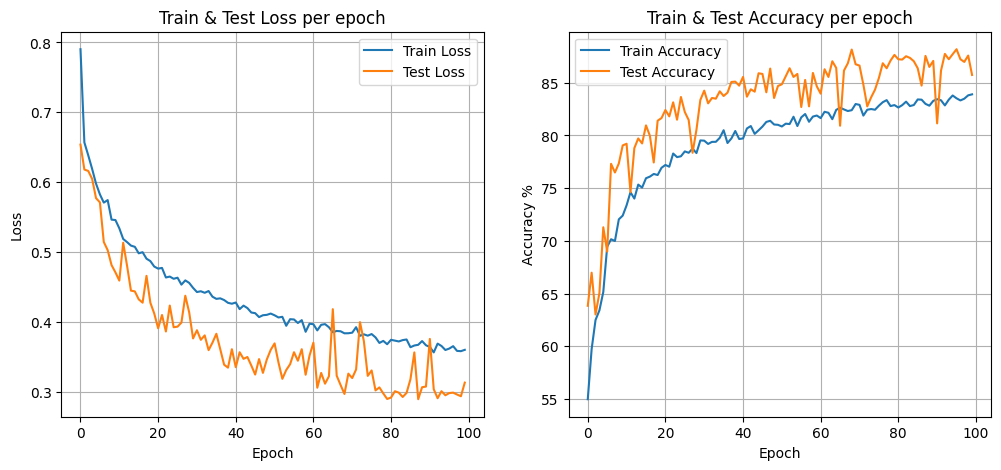

In [86]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), results["train_loss"], label="Train Loss")
plt.plot(range(epochs), results["test_loss"], label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Test Loss per epoch")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), results["train_acc"], label="Train Accuracy")
plt.plot(range(epochs), results["test_acc"], label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy %")
plt.title("Train & Test Accuracy per epoch")
plt.legend()
plt.grid()

In [87]:
from torch.utils.data import Subset

In [88]:
train_100_images = Subset(train_data_augmentation, range(100))
test_20_images = Subset(test_data_augmentation, range(20))

len(train_100_images), len(test_20_images)

(100, 20)

In [89]:
custom_image_path = data_path / "custom_image" / "corgi.jpg"
custom_image_path

WindowsPath('data/custom_image/corgi.jpg')

In [90]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path(data_path / "models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "CatDogClassifier.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
if MODEL_SAVE_PATH.exists():
    print(f"Model already exist: {MODEL_SAVE_PATH}")
else:
    print(f"Save model to: {MODEL_SAVE_PATH}")
    torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: data\models\CatDogClassifier.pth
Model already exist: data\models\CatDogClassifier.pth


In [92]:
from pathlib import Path
import os
import torch
from torch import nn
from PIL import Image
import random
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [93]:
data_path = Path("data/")
test_image_path = data_path / "custom_image" / "corgi.jpg"

test_image_path


WindowsPath('data/custom_image/corgi.jpg')

(-0.5, 999.5, 695.5, -0.5)

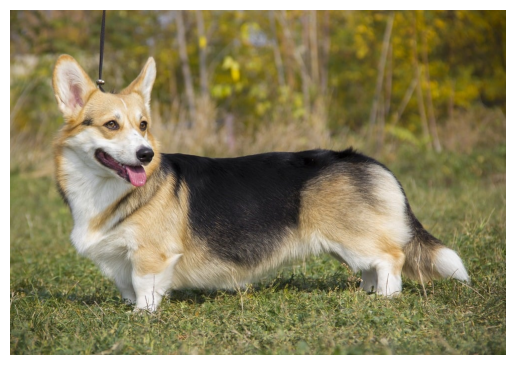

In [29]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
img = Image.open(test_image_path)
img_is_array = np.asarray(img)

plt.imshow(img)
plt.axis(False)

In [30]:
loaded_model = DogVsCat(input_shape=3, hidden_layers=8, output_shape=1)
loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))

loaded_model.to(device)

C:\Users\piotr\AppData\Local\Temp\ipykernel_24216\1882860029.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))


DogVsCat(
  (conv_block_layer_1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_layer_2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU

In [31]:
next(loaded_model.parameters()).device

device(type='cuda', index=0)

In [32]:
test_data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    #transforms.ToTensor()
])

In [33]:
import torchvision

In [34]:
custom_image = torchvision.io.read_image(path=str(test_image_path)).type(torch.float32) / 255
print(f"Custom image shape:\n {custom_image.shape}")
print(f"Custom image datatype:\n {custom_image.dtype}")
custom_image

Custom image shape:
 torch.Size([3, 696, 1000])
Custom image datatype:
 torch.float32


tensor([[[0.2784, 0.2863, 0.2980,  ..., 0.3255, 0.3176, 0.3137],
         [0.2784, 0.2863, 0.3020,  ..., 0.3255, 0.3176, 0.3137],
         [0.2941, 0.3020, 0.3137,  ..., 0.3255, 0.3176, 0.3137],
         ...,
         [0.3725, 0.3529, 0.3373,  ..., 0.2353, 0.2471, 0.2510],
         [0.3843, 0.3647, 0.3490,  ..., 0.2235, 0.2314, 0.2392],
         [0.4314, 0.4039, 0.3725,  ..., 0.2118, 0.2196, 0.2314]],

        [[0.2510, 0.2588, 0.2745,  ..., 0.2706, 0.2627, 0.2588],
         [0.2510, 0.2588, 0.2784,  ..., 0.2706, 0.2627, 0.2588],
         [0.2549, 0.2667, 0.2784,  ..., 0.2706, 0.2627, 0.2588],
         ...,
         [0.3333, 0.3216, 0.3020,  ..., 0.2667, 0.2784, 0.2824],
         [0.3490, 0.3294, 0.3137,  ..., 0.2510, 0.2588, 0.2667],
         [0.3961, 0.3686, 0.3451,  ..., 0.2392, 0.2471, 0.2588]],

        [[0.1373, 0.1451, 0.1490,  ..., 0.0157, 0.0157, 0.0118],
         [0.1373, 0.1451, 0.1529,  ..., 0.0157, 0.0157, 0.0118],
         [0.1490, 0.1529, 0.1569,  ..., 0.0235, 0.0157, 0.

Original shape: torch.Size([3, 696, 1000])
Transformed shape: torch.Size([3, 64, 64])


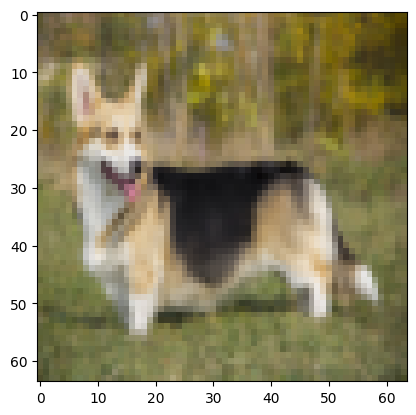

In [35]:
custom_image_transformed = test_data_transform(custom_image)
plt.imshow(custom_image_transformed.permute(1, 2, 0))

# Print out the shapes
print(f"Original shape: {custom_image.shape}")
print(f"Transformed shape: {custom_image_transformed.shape}")

In [36]:
custom_image_transformed.shape, custom_image_transformed.unsqueeze(dim=0).shape

(torch.Size([3, 64, 64]), torch.Size([1, 3, 64, 64]))

In [37]:
loaded_model.eval()
with torch.inference_mode():
    custom_image_pred = loaded_model(custom_image_transformed.unsqueeze(dim=0).to(device))

custom_image_pred

tensor([[0.0424]], device='cuda:0')

In [38]:
class_names

['Cat', 'Dog']

In [39]:
custom_image_pred_label = custom_image_pred.sigmoid()
custom_image_pred_label

tensor([[0.5106]], device='cuda:0')

In [40]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Dopasuj do rozmiaru wejściowego modelu
    transforms.ToTensor(),
])

# Wczytaj obraz i przekształć go
image = Image.open(test_image_path).convert("RGB")
image = transform(image)
image = image.unsqueeze(0) 

In [41]:
image

tensor([[[[0.3569, 0.4118, 0.4392,  ..., 0.3059, 0.3490, 0.3373],
          [0.3608, 0.4314, 0.4863,  ..., 0.3216, 0.3490, 0.3216],
          [0.3490, 0.4118, 0.4627,  ..., 0.3529, 0.2980, 0.3020],
          ...,
          [0.3843, 0.3176, 0.4078,  ..., 0.3686, 0.3294, 0.3804],
          [0.3412, 0.2902, 0.4000,  ..., 0.3333, 0.2863, 0.3451],
          [0.3020, 0.3216, 0.3843,  ..., 0.3294, 0.2588, 0.2745]],

         [[0.3255, 0.3725, 0.3725,  ..., 0.2549, 0.2824, 0.2824],
          [0.3373, 0.3882, 0.4039,  ..., 0.2706, 0.2824, 0.2627],
          [0.3216, 0.3686, 0.3922,  ..., 0.2941, 0.2392, 0.2392],
          ...,
          [0.3725, 0.3373, 0.4196,  ..., 0.3765, 0.3451, 0.3843],
          [0.3373, 0.3137, 0.4118,  ..., 0.3412, 0.3020, 0.3490],
          [0.2980, 0.3373, 0.3961,  ..., 0.3333, 0.2667, 0.2902]],

         [[0.1961, 0.2784, 0.2745,  ..., 0.0275, 0.0078, 0.0275],
          [0.1922, 0.2980, 0.2980,  ..., 0.0314, 0.0118, 0.0118],
          [0.1882, 0.2471, 0.2824,  ..., 0

In [42]:
loaded_model.eval()
with torch.inference_mode():
    output = loaded_model(image.to(device))

pred_label = (output.sigmoid() > 0.5).int().item()
print("Prediction:", pred_label)

Prediction: 1


In [43]:
class_names[pred_label]

'Dog'

(-0.5, 63.5, 63.5, -0.5)

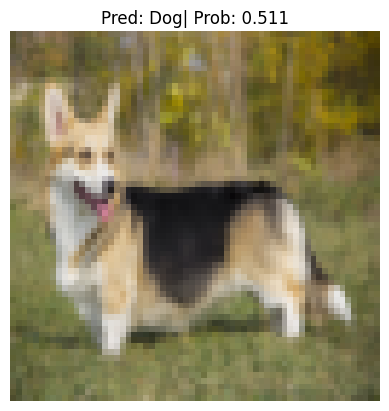

In [44]:
plt.imshow(image.squeeze().permute(1, 2, 0).cpu()) # remove batch dimension and rearrange shape to be HWC

prob = output.sigmoid().cpu().item()

title = f"Pred: {class_names[pred_label]}| Prob: {prob:.3f}"

plt.title(title)
plt.axis(False)

In [45]:
data_path = Path("data/")
test_image_path = data_path / "custom_image" / "cat1.jpg"

(-0.5, 639.5, 390.5, -0.5)

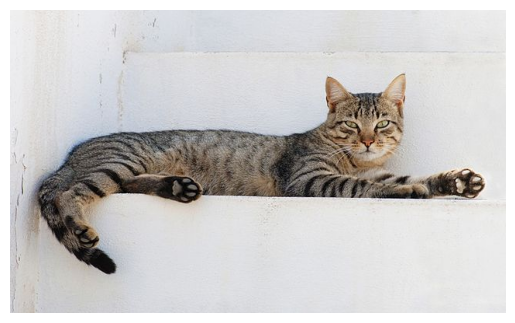

In [46]:
img = Image.open(test_image_path)
img_is_array = np.asarray(img)

plt.imshow(img)
plt.axis(False)


In [48]:
custom_image = torchvision.io.read_image(path=str(test_image_path)).type(torch.float32) / 255
print(f"Custom image shape:\n {custom_image.shape}")
print(f"Custom image datatype:\n {custom_image.dtype}")
custom_image

Custom image shape:
 torch.Size([3, 391, 640])
Custom image datatype:
 torch.float32


tensor([[[0.9412, 0.9412, 0.9412,  ..., 0.9490, 0.9529, 0.9529],
         [0.9412, 0.9412, 0.9412,  ..., 0.9373, 0.9373, 0.9412],
         [0.9412, 0.9412, 0.9412,  ..., 0.9294, 0.9333, 0.9333],
         ...,
         [0.8235, 0.7961, 0.7569,  ..., 0.8941, 0.8980, 0.8980],
         [0.8078, 0.8157, 0.7765,  ..., 0.9020, 0.9020, 0.9059],
         [0.8039, 0.8275, 0.8078,  ..., 0.9020, 0.9020, 0.9059]],

        [[0.9412, 0.9412, 0.9412,  ..., 0.9490, 0.9529, 0.9529],
         [0.9412, 0.9412, 0.9412,  ..., 0.9373, 0.9373, 0.9412],
         [0.9412, 0.9412, 0.9412,  ..., 0.9294, 0.9333, 0.9333],
         ...,
         [0.8196, 0.7922, 0.7529,  ..., 0.8941, 0.8980, 0.8980],
         [0.8039, 0.8118, 0.7725,  ..., 0.9020, 0.9020, 0.9059],
         [0.8000, 0.8235, 0.8039,  ..., 0.9020, 0.9020, 0.9059]],

        [[0.9412, 0.9412, 0.9412,  ..., 0.9490, 0.9529, 0.9529],
         [0.9412, 0.9412, 0.9412,  ..., 0.9373, 0.9373, 0.9412],
         [0.9412, 0.9412, 0.9412,  ..., 0.9294, 0.9333, 0.

Original shape: torch.Size([3, 391, 640])
Transformed shape: torch.Size([3, 64, 64])


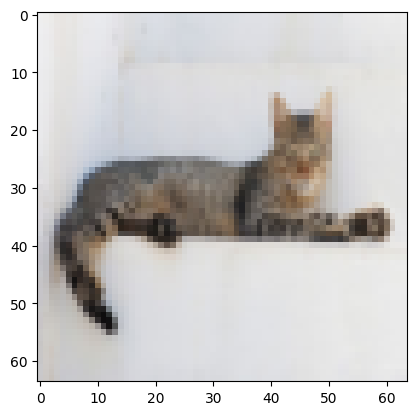

In [49]:
custom_image_transformed = test_data_transform(custom_image)
plt.imshow(custom_image_transformed.permute(1, 2, 0))

# Print out the shapes
print(f"Original shape: {custom_image.shape}")
print(f"Transformed shape: {custom_image_transformed.shape}")

In [50]:
custom_image_transformed.shape, custom_image_transformed.unsqueeze(dim=0).shape

(torch.Size([3, 64, 64]), torch.Size([1, 3, 64, 64]))

In [51]:
loaded_model.eval()
with torch.inference_mode():
    custom_image_pred = loaded_model(custom_image_transformed.unsqueeze(dim=0).to(device))

custom_image_pred

tensor([[0.0408]], device='cuda:0')

In [53]:
custom_image_pred_label = custom_image_pred.sigmoid()
custom_image_pred_label

tensor([[0.5102]], device='cuda:0')